# Air Entrainment Analysis Automatized


## by $\Re\in\Upsilon\sqcap\alpha$

---
<div style="text-align: right"> 
author: R.G. Ramirez de la T.

<div style="text-align: right">
start date: 14-Sep-2018 (extracted from Photron Make Analysis)

<div style="text-align: right">
last modification: 11-Oct-2018
</div>

First we need to import the functions provided by the other notebook: **Photron Analysis Functions**. To do this, we need to run this first cell and then run the cells at the bottom of this notebook after the **Classes for notebook importer** subtitle, where the importer classes are defined and the notebook is imported as a module. 

In [1]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

Then we can import the modules we will use continuosly to make the analysis

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

## Experimental Parameters

The parameters that are permanent through the experimental data presented here (200 to 205) are:

- the diameter of the exit tube: D=0.6cm
- the distance between the exit and the water surface: d=2.0cm (this one changes for other data sets)

The parameters that change through the experiment are:

- the flow rate: f between 1.20 and 2.01 l/min

### Name of the files

The name of the folders and files is defined by a number for example: 204 or 215. This number corresponds to the number in the FlowmeterData file, the letters FLM is just a contraction of FlowMeter. Therefore to know which flow rate we have in the corresponding files we need to extract the flowmeter data, as explained in the **Example** notebook.

The data files for the edges are named accordingly with these numbers and containing *right* or *left* to determine the side of the jet we are looking at. Then for each experimental run we have a "FlometerMeterData_###.lvm" file. a "sobel_right###.txt" file and a "sobel_left###.txt" file.

We can make a loop through the flowmeter files and obtain the mean flow for each experiment presented:

In [9]:
numbers = range(200,206) #number in Flowmete files

for i in numbers:
    name_flow = '../flowmeter/FlowMeterData_'+str(i)+'.lvm'
    t,flow = Phot.lvm_unpack(name_flow) #extract the flow data
    mean_flow = Phot.Mean_Flow(flow)  #calculate the mean flow
    print('For the files with number '+str(i)+' the mean flow is %.2f'%mean_flow)

For the files with number 200 the mean flow is 1.24
For the files with number 201 the mean flow is 1.43
For the files with number 202 the mean flow is 1.72
For the files with number 203 the mean flow is 1.65
For the files with number 204 the mean flow is 1.83
For the files with number 205 the mean flow is 2.01


### Scale pixels/mm obtain from the images

Each experimental run has its own scaling because the distance between the camera and the jet can change. By previous calibration of the images we can obtain the correct scaling for each set:

- Folders with numbers 185 to 192 the scaling is: 1mm=25.6px
- Folders with numbers 200 to 205 the scaling is: 1mm=49.07px
- Folders with numbers 206 to 214 the scaling is: 1mm=44.15px
- Folders with numbers 215 to 218 the scaling is: 1mm=47.46px

As we work with folder 200 to 205, we set the correspondant scale:

In [26]:
scale = 49.07 

## Different types of analysis

## Waves Speed by cross-correlation

In this section, for each flow rate, we compare waves in two different images (timesteps) by making a cross-correlation. We determine if the waves we are looking at are the same wave dislpaced and then calculate the wave speed. Finally we make a histogram of the encountered wave speeds.

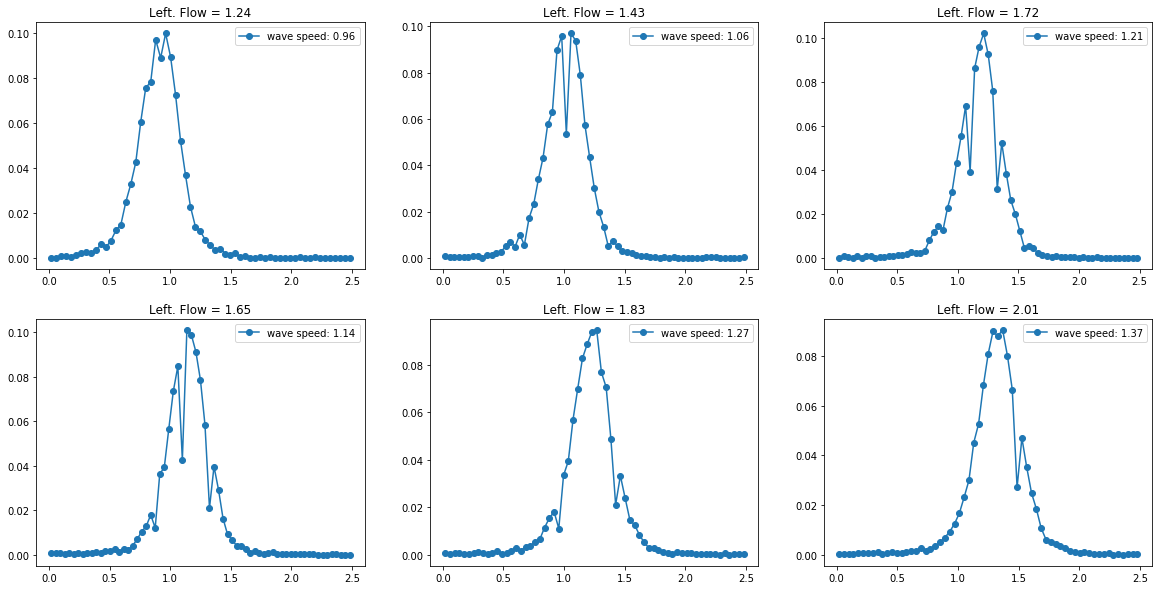

In [34]:
plt.figure(figsize=(20,10))
peaks = np.zeros(6)
stds  = np.zeros(6)
for num in range(200,206):
    #read flowmeter data and obtain the mean
    name_flow = '../flowmeter/FlowMeterData_'+str(num)+'.lvm'
    t,flow = Phot.lvm_unpack(name_flow) 
    mean_flow = Phot.Mean_Flow(flow)
    #read the data files for the left side
    txt_name_l = 'sobel_left'+str(num)+'.txt'
    data_l = np.loadtxt(txt_name_l,unpack=True)
    no_images = data_l.shape[0]
    lines = 800 #data_l.shape[1]
    left = np.zeros((no_images,lines))
    #Smooth the data
    for i in range(no_images):
        wave_l = Phot.smooth(data_l[i,0:lines],window_len=100,window='hanning')
        left[i,:] = wave_l
    #Find the zero crossing
    waves_left = Phot.substract_zero_crossing_time(left)
    indexes = []
    no_waves = []
    #Use routine to find different waves in each image(timestep)
    for i in range(no_images):
        try:
            sep = Phot.Find_waves(waves_left[i,:],'left')
            indexes.append(sep)
            no_waves.append(len(sep)-1)
        except:
            indexes.append(0)
            no_waves.append(0)
    #speeds = []
    #pairs = []
    hist_speed = [] #list to allocate found speeds
    for i in range(0,no_images-1):
        speed = []
        #pair = []
        number1 = no_waves[i]
        number2 = no_waves[i+1]
        idx = indexes[i]
        idx2 = indexes[i+1]
        if number1 == 0:
            #speeds.append(0)
            #pairs.append(0)
            continue
        if number2 == 0:
            #speeds.append(0)
            #pairs.append(0)
            continue

        for j in range(number1):

        #pair the first wave in each image
            patch1 = np.zeros_like(waves_left[i,:])
            patch1[idx[j]:idx[j+1]] = waves_left[i,idx[j]:idx[j+1]]
            #loop through waves in the second image
            for k in range(number2):

                patch2 = np.zeros_like(waves_left[i+1,:])
                patch2[idx2[k]:idx2[k+1]] = waves_left[i+1,idx2[k]:idx2[k+1]]
                length = len(patch1)+len(patch2)
                center = length/2
                #check the crosscorrelation
                corr = (scipy.signal.correlate(patch1/patch1.std(),patch2/patch2.std()))/center
                peak = np.max(corr)
                ind = np.argmax(corr)
                #If the crosscorrelation peak is high they are the same wave
                if peak >= 0.80:
                    vel = center-ind
                    if vel<=0:
                        vel = 0
                    if vel > 0:
                        #speed.append(vel)
                        hist_speed.append(vel)

                    break
            
            if not speed:
                speed.append(0)
            

    #scale speed to m/s
    hist_speed = np.array(hist_speed)/scale
    hist, bins = np.histogram(hist_speed,bins='scott',range=(0,2.5))
    total_parts = len(hist_speed)
    norm = hist/float(total_parts)
    ind = np.argmax(hist)
    center = (bins[:-1] + bins[1:]) / 2
    plt.subplot(2,3,num-199),plt.plot(center,norm,'o-',label='wave speed: %.2f' % center[ind])
    plt.legend()
    plt.title('Left. Flow = %.2f' % mean_flow)
    peaks[num-200] = center[ind]
    stds[num-200] = np.std(hist_speed)/scale 

## Calculation of falling jet speed

Using the mean flow extracted from the data files we calculate the initial velocity of the jet and we add the velocity of the free fall. We also calculate the momentum

For the falling velocity:
$$ V_{i} = Q/A, \quad V_{f} = \sqrt{V_{i}^{2}+2gd}$$

For the momentum:
$$\Delta M = \Delta m V_{f} = \rho Q \Delta t V_{f}$$

where:

$Q$:flow, $A$:area$(\pi r^{2})$, $g$:gravity accel., $d$:falling distance, $m$:mass, $\rho$:density, $\Delta t$:timestep 

In [39]:
jet_vels = np.zeros(6)
jet_flow = np.zeros(6)
init_vel = np.zeros(6)
momentum = np.zeros(6)
area = (0.003)**2*np.pi
for num in range(200,206):
    name_flow = '../flowmeter/FlowMeterData_'+str(num)+'.lvm'
    t,flow = Phot.lvm_unpack(name_flow)
    #scale to m^3/s
    mean_flow = (Phot.Mean_Flow(flow))/6.0e4
    init = mean_flow/area
    jet_vel = np.sqrt(init**2+2.*9.8*0.02)
    mom = mean_flow*jet_vel
    jet_flow[num-200] = mean_flow
    init_vel[num-200] = init
    jet_vels[num-200] = jet_vel
    momentum[num-200] = mom
deriv = 0.5/jet_vels
dev = deriv*(0.33e-2+2*9.8*0.001)

In [40]:
init_vel

array([0.73332907, 0.84006848, 1.01624644, 0.97346269, 1.076424  ,
       1.18272436])

In [41]:
jet_vels

array([0.96424661, 1.04771898, 1.19363178, 1.1574237 , 1.24526649,
       1.33822155])

Then we can compare the falling velocities with the wave speeds by plotting them together

Text(0.5,1,'Wave Speed vs Jet Velocity')

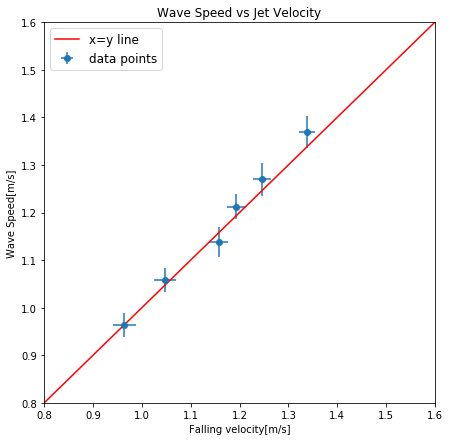

In [43]:
fig = plt.figure(figsize=(7,7))
plt.errorbar(jet_vels,peaks,yerr=2*stds,xerr=2*dev,fmt='o',label='data points')
plt.plot([0,1,2],[0,1,2],'r',label='x=y line')
plt.xlim(0.8,1.6)
plt.ylim(0.8,1.6)
plt.xlabel('Falling velocity[m/s]')
plt.ylabel('Wave Speed[m/s]')
plt.legend(fontsize='large')
plt.title('Wave Speed vs Jet Velocity')

We can se that the Jet Velocity and the Wave speed is the same. We can confirm by adjusting a straight line to our data:

Text(0.5,1,'Wave Speed vs Jet Velocity')

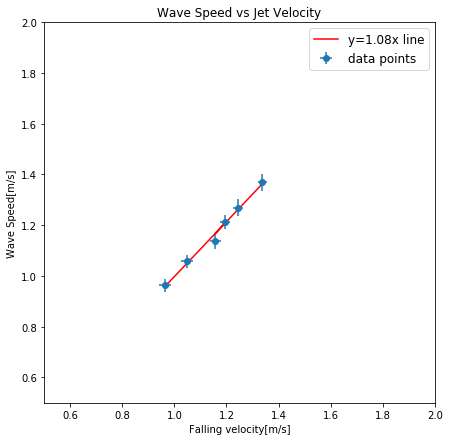

In [44]:
z = np.polyfit(jet_vels,peaks,1)
func = np.poly1d(z)

fig = plt.figure(figsize=(7,7))
plt.errorbar(jet_vels,peaks,yerr=2*stds,xerr=2*dev,fmt='o',label='data points')
plt.plot(jet_vels,func(jet_vels),'r',label='y=%.2fx line'%z[0])
plt.xlim(0.5,2)
plt.ylim(0.5,2)
plt.xlabel('Falling velocity[m/s]')
plt.ylabel('Wave Speed[m/s]')
plt.legend(fontsize='large')
plt.title('Wave Speed vs Jet Velocity')

## Position of the crest against amplitude and wavelength against amplitude

We intend to make a representation of the position of the waves compared with there amplitude and wavelegth. We find that for all flow rates the graphs look very similar.

Some changes are necessary in the analysis. For example, count waves only once. 

200
201
202
203
204
205


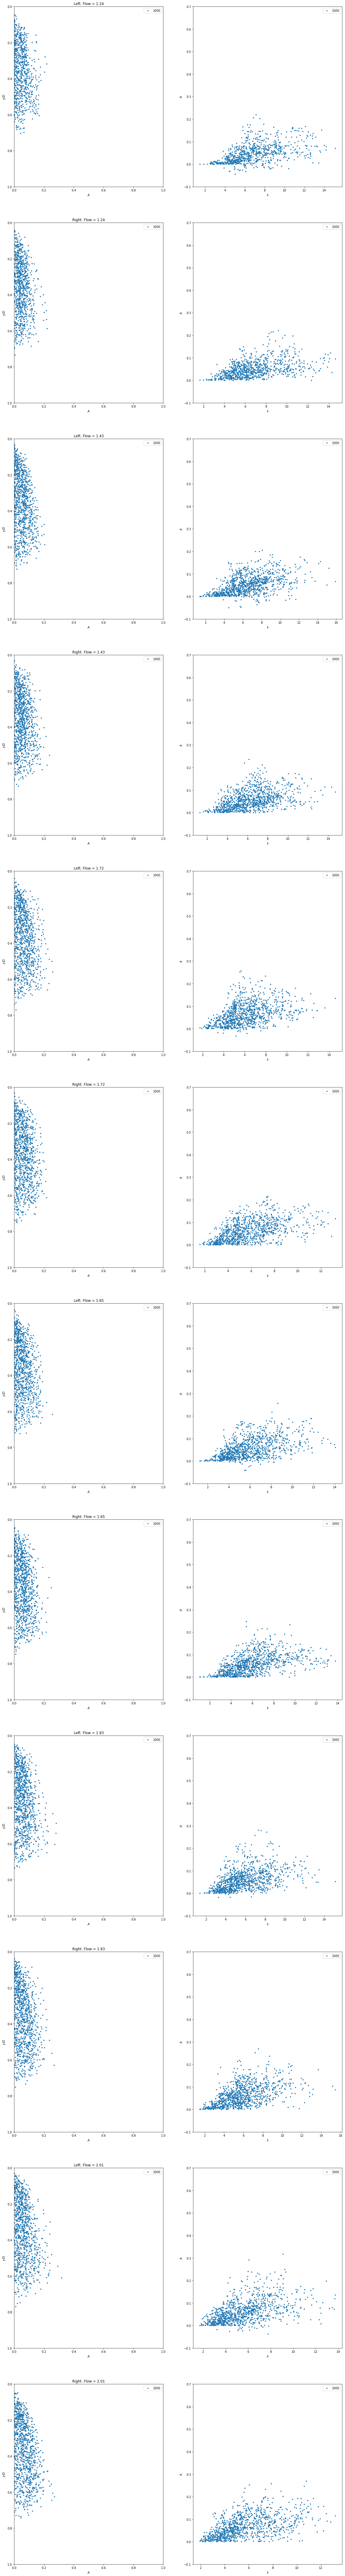

In [45]:
fig = plt.figure(figsize=(20,160))
for i in range(200,206):
    print(i)
    txt_name_r = 'sobel_right'+str(i)+'.txt'
    txt_name_l = 'sobel_left'+str(i)+'.txt'
    data_l = np.loadtxt(txt_name_l,unpack=True)
    data_r = np.loadtxt(txt_name_r,unpack=True)
    name_flow = '../flowmeter/FlowMeterData_'+str(i)+'.lvm'
    t,flow = Phot.lvm_unpack(name_flow)
    mean_flow = Phot.Mean_Flow(flow)
    
    no_images = 1000#data_l.shape[0]
    left = np.zeros((no_images,800))
    right = np.zeros((no_images,800))
    for j in range(no_images):
        wave_l = Phot.smooth(data_l[j,0:800],window_len=100,window='hanning')
        wave_r = Phot.smooth(data_r[j,0:800],window_len=100,window='hanning')
        left[j,:] = wave_l
        right[j,:] = wave_r
        
    indexes_left = []
    waves_left = Phot.substract_zero_crossing_time(left)
    A_left = []
    L_left = []
    crest_left = []
    no_waves_left = []

    for j in range(0,no_images):
        try:
            sep = Phot.Find_waves(waves_left[j,:],'left')
            indexes_left.append(sep)
            no_waves_left.append(len(sep)-1)
            for k in range(len(sep)-1):
                onda = waves_left[j,sep[k]:sep[k+1]]
                
                wavelength = (sep[k+1]-sep[k])/scale  #definied at the beginning
                amplitude = max(onda)/scale #defined at the beginning
                A_left.append(amplitude)
                L_left.append(wavelength)
                crest_left.append(sep[k]+np.argmax(onda))
        except:
            indexes_left.append(0)
            no_waves_left.append(0)

    indexes_right = []
    waves_right = Phot.substract_zero_crossing_time(right)
    A_right = []
    L_right = []
    crest_right = []
    no_waves_right = []

    for j in range(0,no_images):
        try:
            sep = Phot.Find_waves(waves_right[j,:],'right',20)
            indexes_right.append(sep)
            no_waves_right.append(len(sep)-1)
            for k in range(len(sep)-1):
                onda = waves_right[j,sep[k]:sep[k+1]]
                wavelength = (sep[k+1]-sep[k])/scale 
                amplitude = abs(min(onda)/scale) 
                A_right.append(amplitude)
                L_right.append(wavelength)
                crest_right.append(sep[k]+np.argmin(onda))
        except:
            indexes_right.append(0)
            no_waves_right.append(0)
            
    K_left = 2*np.pi/np.array(L_left)
    K_right = 2*np.pi/np.array(L_right)
    y_left = np.array(crest_left)/float(data_l.shape[1])
    y_right = np.array(crest_right)/float(data_l.shape[1])
    
    plt.subplot(12,2,1+4*(i-200))
    n = no_images/1000
    for j in range(n):#(n)
        plt.plot(A_left[j*1000:(j+1)*1000-1],y_left[j*1000:(j+1)*1000-1],'.',label=str((j+1)*1000))
    plt.ylim(1,0)
    plt.xlim(0,1)
    plt.legend()
    plt.title('Left. Flow = %.2f' % mean_flow)
    plt.xlabel('$A$')
    plt.ylabel('$y/D$')
    
    plt.subplot(12,2,2+4*(i-200))
    for j in range(n):
        plt.plot(L_left[j*1000:(j+1)*1000-1],A_left[j*1000:(j+1)*1000-1],'.',label=str((j+1)*1000))
    plt.xlabel('$\lambda$')
    plt.ylabel('$A$')
    plt.ylim(-0.1,0.7)
    plt.legend()
    
    plt.subplot(12,2,3+4*(i-200))
    for j in range(n): #(n)
        plt.plot(A_right[j*1000:(j+1)*1000-1],y_right[j*1000:(j+1)*1000-1],'.',label=str((j+1)*1000))
    plt.ylim(1,0)
    plt.xlim(0,1)
    plt.legend()
    plt.title('Right. Flow = %.2f' % mean_flow)
    plt.xlabel('$A$')
    plt.ylabel('$y/D$')
    
    plt.subplot(12,2,4+4*(i-200))
    for j in range(n):
        plt.plot(L_right[j*1000:(j+1)*1000-1],A_right[j*1000:(j+1)*1000-1],'.',label=str((j+1)*1000))
    plt.xlabel('$\lambda$')
    plt.ylabel('$A$')
    plt.ylim(-0.1,0.7)
    plt.legend()
plt.show()

## Histogram of steepness at different flow rates

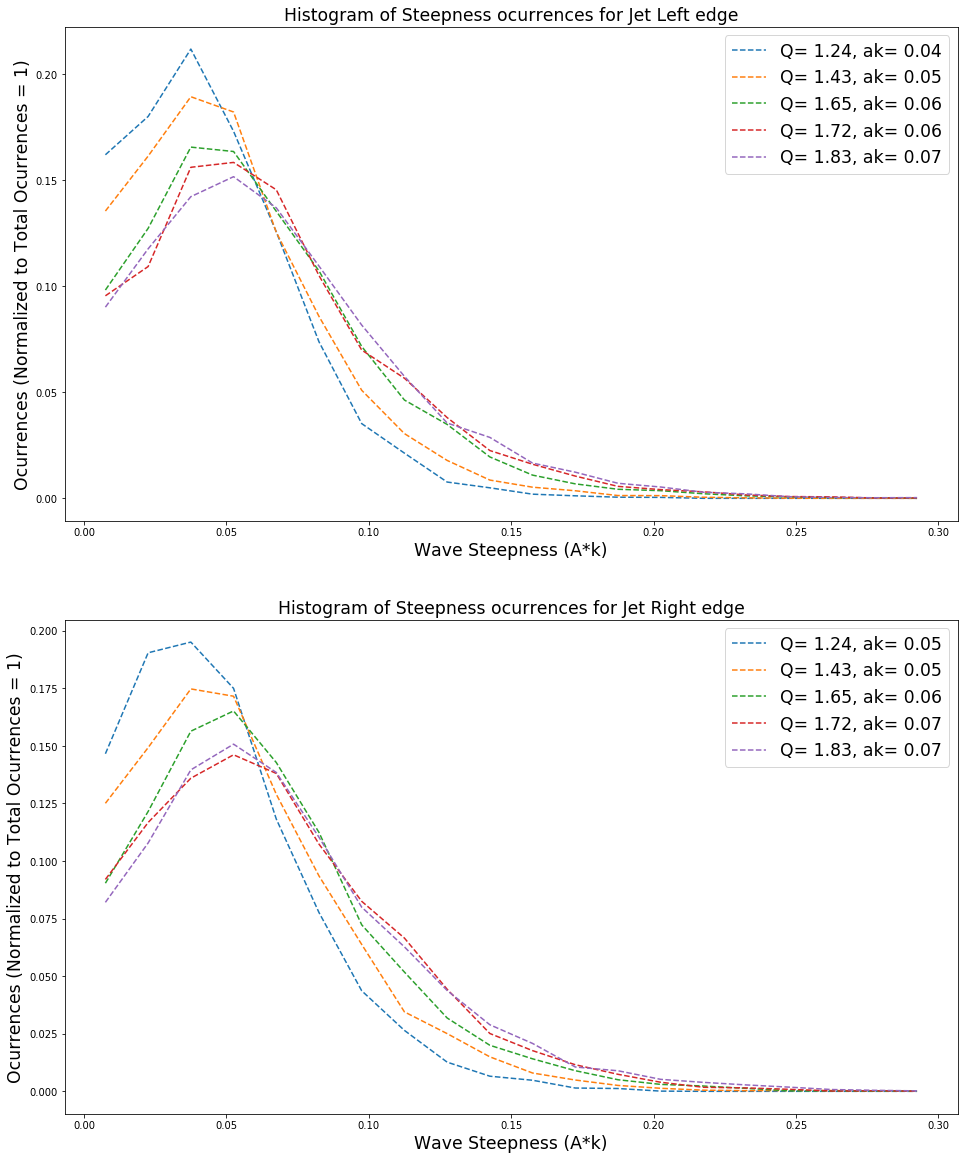

In [46]:
fig = plt.figure(figsize=(16,20))
#First axis for the left side
ax1 = plt.subplot(2,1,1)
#Second axis for the right side
ax2 = plt.subplot(2,1,2)
for i in range(200,206):
    print(i)
    #Flip 202 and 203 to obtain the right flow order in graphs
    if i==202:
        #Extract data Files
        txt_name_r = 'sobel_right'+str(i+1)+'.txt'
        txt_name_l = 'sobel_left'+str(i+1)+'.txt'
        data_l = np.loadtxt(txt_name_l,unpack=True)
        data_r = np.loadtxt(txt_name_r,unpack=True)
        #Extract flow data
        name_flow = '../flowmeter/FlowMeterData_'+str(i+1)+'.lvm'
        t,flow = Phot.lvm_unpack(name_flow)
        mean_flow = Phot.Mean_Flow(flow)
    elif i==203:
        #Extract data Files
        txt_name_r = 'sobel_right'+str(i-1)+'.txt'
        txt_name_l = 'sobel_left'+str(i-1)+'.txt'
        data_l = np.loadtxt(txt_name_l,unpack=True)
        data_r = np.loadtxt(txt_name_r,unpack=True)
        #Extract flow data
        name_flow = '../flowmeter/FlowMeterData_'+str(i-1)+'.lvm'
        t,flow = Phot.lvm_unpack(name_flow)
        mean_flow = Phot.Mean_Flow(flow)
    else:
        #Extract data Files
        txt_name_r = 'sobel_right'+str(i)+'.txt'
        txt_name_l = 'sobel_left'+str(i)+'.txt'
        data_l = np.loadtxt(txt_name_l,unpack=True)
        data_r = np.loadtxt(txt_name_r,unpack=True)
        #Extract flow data
        name_flow = '../flowmeter/FlowMeterData_'+str(i)+'.lvm'
        t,flow = Phot.lvm_unpack(name_flow)
        mean_flow = Phot.Mean_Flow(flow)
    #Alocate space for data
    no_images = data_l.shape[0]
    left = np.zeros((no_images,800)) #for 200:205 I cutted until 800
    right = np.zeros((no_images,800))
    
    for j in range(no_images):
        #Smoothing data line by line and fill the data matrixes
        wave_l = Phot.smooth(data_l[j,0:800],window_len=100,window='hanning') #for 200:205 the parenthesis is [j,:800]
        wave_r = Phot.smooth(data_r[j,0:800],window_len=100,window='hanning') #for 200:205 the parenthesis is [j,:800]
        left[j,:] = wave_l
        right[j,:] = wave_r
        
    #ANALYSIS FOR THE LEFT SIDE
    #Make zero crossings in data
    waves_left = Phot.substract_zero_crossing(left)
    #Empty list to collect variable data
    indexes_left = []
    A_left = []
    L_left = []
    crest_left = []
    no_waves_left = []
    #Loop for each timestep
    for j in range(0,no_images):
        #There are images where the output of Find_waves is empty
        # in that case we just store zeros in the corresponding lists
        try:
            #Find the troughs and collect the information
            sep = Phot.Find_waves(waves_left[j,:],'left')
            indexes_left.append(sep)
            no_waves_left.append(len(sep)-1)
            #separate each wave and calculate amplitude and wavelegth
            for k in range(len(sep)-1):
                onda = waves_left[j,sep[k]:sep[k+1]]
                wavelength = (sep[k+1]-sep[k])/scale #scaling dependant on images
                amplitude = abs(max(onda))/scale     #scaling dependant on images
                A_left.append(amplitude)
                L_left.append(wavelength)
                crest_left.append(sep[k]+np.argmax(onda))
        except:
            indexes_left.append(0)
            no_waves_left.append(0)

    #ANALYSIS FOR THE RIGHT SIDE
    #Make zero crossing in data
    waves_right = Phot.substract_zero_crossing(right)
    #Empty lists to collect variable data
    indexes_right = []
    A_right = []
    L_right = []
    crest_right = []
    no_waves_right = []
    #Loop for each time step
    for j in range(0,no_images):
        #There are images where the output of Find_waves is empty
        # in that case we just store zeros in the corresponding lists
        try:
            #Find the troughs and collect the information
            sep = Phot.Find_waves(waves_right[j,:],'right')
            indexes_right.append(sep)
            no_waves_right.append(len(sep)-1)
            #separate each wave and calculate amplitude and wavelegth
            for k in range(len(sep)-1):
                onda = waves_right[j,sep[k]:sep[k+1]]
                wavelength = (sep[k+1]-sep[k])/scale  #scaling dependant on images
                amplitude = abs(min(onda))/scale      #scaling dependant on images
                A_right.append(amplitude)
                L_right.append(wavelength)
                crest_right.append(sep[k]+np.argmin(onda))
        except:
            indexes_right.append(0)
            no_waves_right.append(0)
    #Calculate wavenumber, steepness and their errors    
    K_left = 2*np.pi/np.array(L_left)
    K_right = 2*np.pi/np.array(L_right)
    dK_l = 0.02*K_left/np.array(L_left)
    dK_r = 0.02*K_right/np.array(L_right)
    steepness_left = A_left*K_left
    steepness_right = A_right*K_right
    dst_l = 0.02*K_left*(1.+A_left/np.array(L_left))
    dst_r = 0.02*K_right*(1.+A_right/np.array(L_right))
    #Calculate the weigth of data for histogram
    we_ak_l = 1./dst_l
    we_ak_r =1./dst_r
    #Make weigthed normalized histograms
    hist_left, bins_left = np.histogram(steepness_left,bins=20,range=(0,0.3),weights=we_ak_l,density=True)
    hist_right, bins_right = np.histogram(steepness_right,bins=20,range=(0,0.3),weights=we_ak_r,density=True)
    
    #numpy.histogram integral is one when bins are size one, so we need to
    # multiply by the bin sizes to renormalize
    norm_l = hist_left*abs(bins_left[1]-bins_left[0])
    norm_r = hist_right*abs(bins_right[1]-bins_right[0])
    #mean steepness
    ind_l = np.mean(steepness_left)
    ind_r = np.mean(steepness_right)
    center_l = (bins_left[:-1] + bins_left[1:]) / 2
    center_r = (bins_right[:-1] + bins_right[1:]) / 2
    ax1.plot(center_l,norm_l,'--',label='Q= %.2f, ak= %.2f' % (mean_flow,ind_l))
    ax2.plot(center_r,norm_r,'--',label='Q= %.2f, ak= %.2f' % (mean_flow,ind_r))
    ax1.legend(fontsize='xx-large')
    ax2.legend(fontsize='xx-large')
    ax1.set_xlabel('Wave Steepness (A*k)',fontsize='xx-large')
    ax1.set_ylabel('Ocurrences (Normalized to Total Ocurrences = 1)',fontsize='xx-large')
    ax2.set_xlabel('Wave Steepness (A*k)',fontsize='xx-large')
    ax2.set_ylabel('Ocurrences (Normalized to Total Ocurrences = 1)',fontsize='xx-large')
    ax1.set_title('Histogram of Steepness ocurrences for Jet Left edge',fontsize='xx-large')
    ax2.set_title('Histogram of Steepness ocurrences for Jet Right edge',fontsize='xx-large')
plt.show()

In [47]:
sum(norm_l)

1.0

## Histogram of symmetry

Make a histogram of the symmetry of the waves to determine if it is aslo a factor in the generation of bubbles.

The main procedure is to find the crest of the wave and then compare its position with half of the wavelength. We can make this compariosn by defining the symmetry parameter:

$$sym =\frac{X_{crest}}{\lambda / 2}=\frac{2 X_{crest}}{\lambda}$$

Then we see if $sym < 1$ the back part of the wave is smaller than the front and therefore if $sym > 1$ the front part of the wave is smaller than the back. Finally if $sym = 1$ the wave is symmentric.

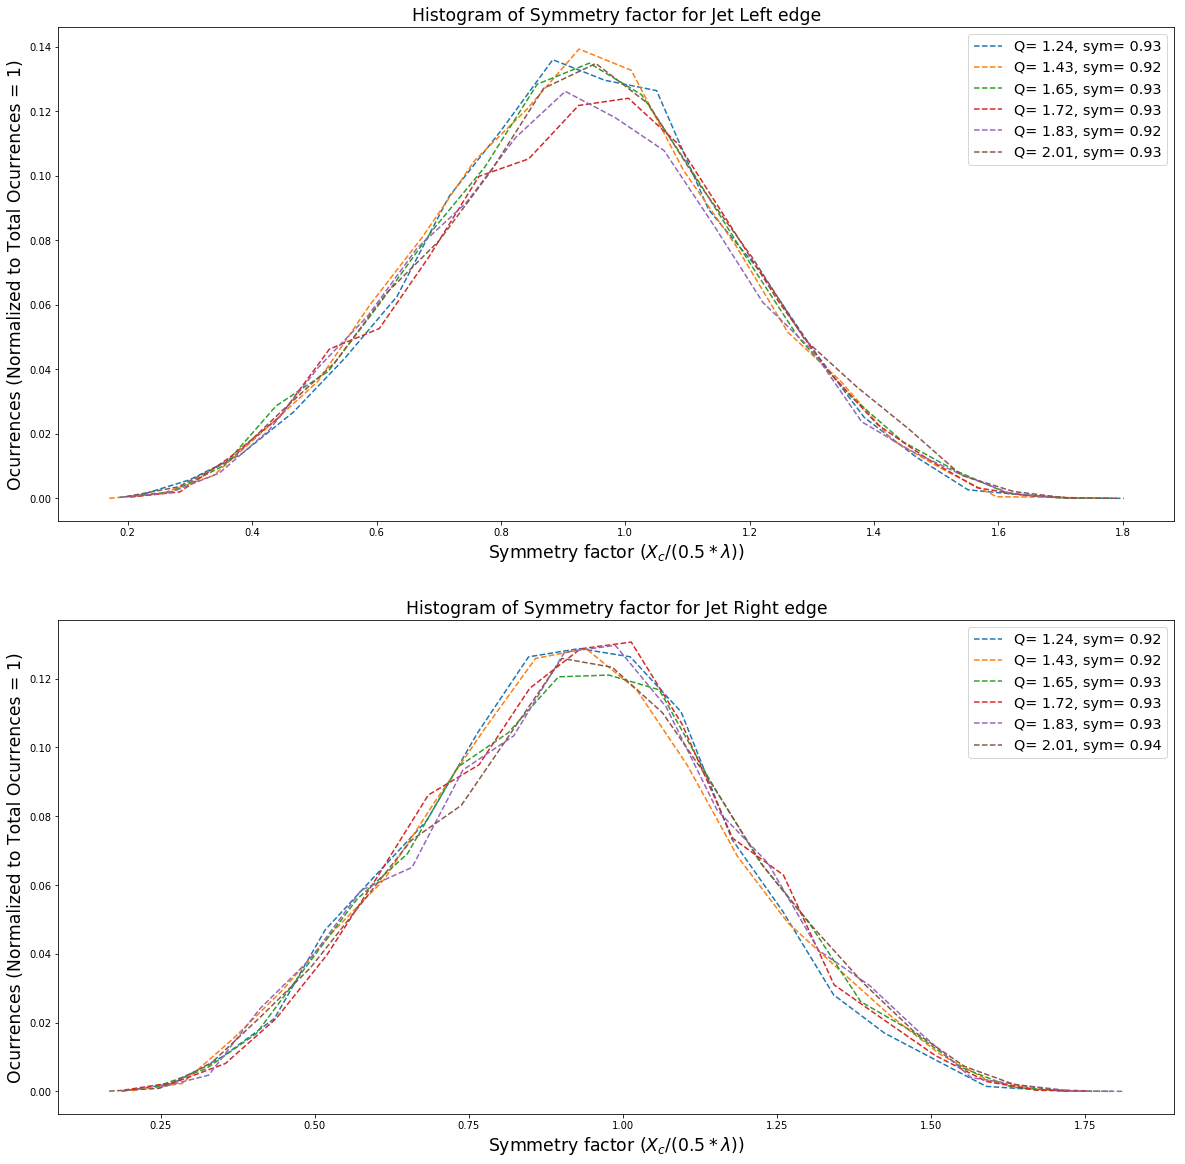

In [48]:
fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)
for i in range(200,206):
   #Flip 202 and 203 to obtain the right flow order in graphs
    if i==202:
        #Extract data Files
        txt_name_r = 'sobel_right'+str(i+1)+'.txt'
        txt_name_l = 'sobel_left'+str(i+1)+'.txt'
        data_l = np.loadtxt(txt_name_l,unpack=True)
        data_r = np.loadtxt(txt_name_r,unpack=True)
        #Extract flow data
        name_flow = '../flowmeter/FlowMeterData_'+str(i+1)+'.lvm'
        t,flow = Phot.lvm_unpack(name_flow)
        mean_flow = Phot.Mean_Flow(flow)
    elif i==203:
        #Extract data Files
        txt_name_r = 'sobel_right'+str(i-1)+'.txt'
        txt_name_l = 'sobel_left'+str(i-1)+'.txt'
        data_l = np.loadtxt(txt_name_l,unpack=True)
        data_r = np.loadtxt(txt_name_r,unpack=True)
        #Extract flow data
        name_flow = '../flowmeter/FlowMeterData_'+str(i-1)+'.lvm'
        t,flow = Phot.lvm_unpack(name_flow)
        mean_flow = Phot.Mean_Flow(flow)
    else:
        #Extract data Files
        txt_name_r = 'sobel_right'+str(i)+'.txt'
        txt_name_l = 'sobel_left'+str(i)+'.txt'
        data_l = np.loadtxt(txt_name_l,unpack=True)
        data_r = np.loadtxt(txt_name_r,unpack=True)
        #Extract flow data
        name_flow = '../flowmeter/FlowMeterData_'+str(i)+'.lvm'
        t,flow = Phot.lvm_unpack(name_flow)
        mean_flow = Phot.Mean_Flow(flow)
    
    #Alocate space for data
    no_images = data_l.shape[0]
    left = np.zeros((no_images,800))
    right = np.zeros((no_images,800))
    for j in range(no_images):
        #Smoothing data line by line and fill the data matrixes
        wave_l = Phot.smooth(data_l[j,0:800],window_len=100,window='hanning')
        wave_r = Phot.smooth(data_r[j,0:800],window_len=100,window='hanning')
        left[j,:] = wave_l
        right[j,:] = wave_r
    #ANALYSIS FOR THE LEFT SIDE
    #Make zero crossings in data    
    waves_left = Phot.substract_zero_crossing(left)
    #Make empty lists to store variable data
    indexes_left = []
    A_left = []
    L_left = []
    no_waves_left = []
    back_left=[]
    #Loop for each time step
    for j in range(0,no_images):
        #There are images where the output of Find_waves is empty
        # in that case we just store zeros in the corresponding lists
        try:
            #Find the troughs and collect the information
            sep = Phot.Find_waves(waves_left[j,:],'left')
            indexes_left.append(sep)
            no_waves_left.append(len(sep)-1)
            #separate each wave and calculate amplitude and wavelegth
            for k in range(len(sep)-1):
                onda = waves_left[j,sep[k]:sep[k+1]]
                wavelength = (sep[k+1]-sep[k])/scale #scaling dependant on images
                amplitude = max(onda)/scale          #scaling dependant on images
                A_left.append(amplitude)
                L_left.append(wavelength)
                #calculate also symmetry factor for each wave
                back_left.append(2.*np.argmax(onda)/(wavelength*scale))
        except:
            indexes_left.append(0)
            no_waves_left.append(0)
    #ANALYSIS FOR THE LEFT SIDE
    #Make zero crossings in data
    
    waves_right = Phot.substract_zero_crossing(right)
    #Make empty lists to store variable data
    indexes_right = []
    A_right = []
    L_right = []
    no_waves_right = []
    back_right = []
    #Loop for each time step
    for j in range(0,no_images):
        #There are images where the output of Find_waves is empty
        # in that case we just store zeros in the corresponding lists
        try:
            #Find the troughs and collect the information
            sep = Phot.Find_waves(waves_right[j,:],'right')
            indexes_right.append(sep)
            no_waves_right.append(len(sep)-1)
            #separate each wave and calculate amplitude and wavelegth
            for k in range(len(sep)-1):
                onda = waves_right[j,sep[k]:sep[k+1]]
                wavelength = (sep[k+1]-sep[k])/scale  #scaling dependant on images
                amplitude = abs(min(onda))/scale      #scaling dependant on images
                A_right.append(amplitude)
                L_right.append(wavelength)
                #Calculate symmetry factor
                back_right.append(2.*np.argmin(onda)/(wavelength*scale))
        except:
            indexes_right.append(0)
            no_waves_right.append(0)
            
    #Calculate errors for symmetry factor to creat weights
    devs_left = 0.04*(1+np.array(back_left))/A_left
    devs_right = 0.04*(1+np.array(back_right))/A_right
    #calculate weights for histograms 
    we_left=1./devs_left
    we_right=1./devs_right
    #Make weighted normalized histograms fos symmetry factor
    hist_left, bins_left = np.histogram(back_left,bins=20,weights=we_left,density=True)
    hist_right, bins_right = np.histogram(back_right,bins=20,weights=we_right,density=True)
    #Find peak in histogram
    cen_l = np.average(back_left,weights=we_left)
    cen_r = np.average(back_right,weights=we_right)
    #numpy.histogram normalizes to one when the bins size is 1. We renormalize
    # multiplying by the bin size. 
    norm_l = hist_left*abs(bins_left[1]-bins_left[0])
    norm_r = hist_right*abs(bins_right[1]-bins_right[0])
    center_l = (bins_left[:-1] + bins_left[1:]) / 2
    center_r = (bins_right[:-1] + bins_right[1:]) / 2
    ax1.plot(center_l,norm_l,'--',label='Q= %.2f, sym= %.2f' % (mean_flow,cen_l))
    ax2.plot(center_r,norm_r,'--',label='Q= %.2f, sym= %.2f' % (mean_flow,cen_r))
    ax1.legend(fontsize='x-large')
    ax2.legend(fontsize='x-large')
    ax1.set_xlabel(r'Symmetry factor ($X_c/(0.5*\lambda)$)',fontsize='xx-large')
    ax1.set_ylabel('Ocurrences (Normalized to Total Ocurrences = 1)',fontsize='xx-large')
    ax2.set_xlabel(r'Symmetry factor ($X_c/(0.5*\lambda)$)',fontsize='xx-large')
    ax2.set_ylabel('Ocurrences (Normalized to Total Ocurrences = 1)',fontsize='xx-large')
    ax1.set_title('Histogram of Symmetry factor for Jet Left edge',fontsize='xx-large')
    ax2.set_title('Histogram of Symmetry factor for Jet Right edge',fontsize='xx-large')
plt.show()

## Compare 2cm against 4cm

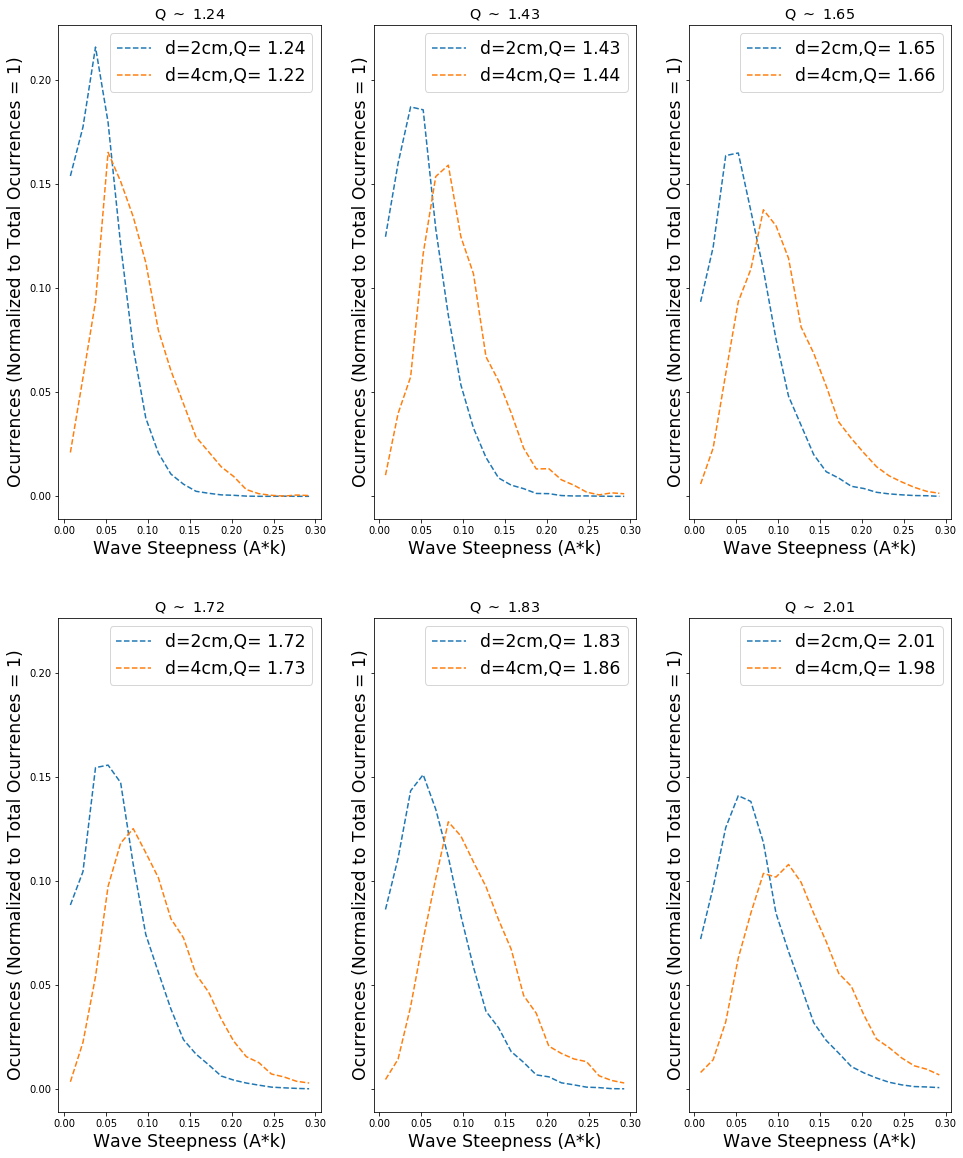

In [243]:
fig, axs = plt.subplots(2,3,sharey=True,figsize=(16,20))
axes = axs.flatten()
#List number of files with different flows in ascendant order
list_2cm = [200,201,203,202,204,205]
list_4cm = [214,213,212,211,210,209]
#scales are different as we took images in different days
scale1 = 49.07
scale2 = 44.15

#loop for the elements in the list
for i in range(6):
    num1 = list_2cm[i]
    num2 = list_4cm[i]
    #Extract data Files
    txt_name_2cm = 'sobel_left'+str(num1)+'.txt'
    txt_name_4cm = 'sobel_left'+str(num2)+'.txt'
    data_2 = np.loadtxt(txt_name_2cm,unpack=True)
    data_4 = np.loadtxt(txt_name_4cm,unpack=True)
    #Extract flow data
    name_flow_2cm = '../flowmeter/FlowMeterData_'+str(num1)+'.lvm'
    name_flow_4cm = '../flowmeter/FlowMeterData_'+str(num2)+'.lvm'
    t,flow2 = Phot.lvm_unpack(name_flow_2cm)
    mean_flow2 = Phot.Mean_Flow(flow2)
    t,flow4 = Phot.lvm_unpack(name_flow_4cm)
    mean_flow4 = Phot.Mean_Flow(flow4)
    #Alocate space for data
    
    #We assume the number of analyzed images in both is the same
    no_images = data_2.shape[0]
    l_2 = np.zeros((no_images,data_2.shape[1]))
    l_4 = np.zeros((no_images,data_4.shape[1]))
    
    for j in range(no_images):
        #Smoothing data line by line and fill the data matrixes
        wave_2 = Phot.smooth(data_2[j,:],window_len=100,window='hanning')
        wave_4 = Phot.smooth(data_4[j,:],window_len=100,window='hanning')
        l_2[j,:] = wave_2
        l_4[j,:] = wave_4
        
    #ANALYSIS FOR THE 2cm
    #Make zero crossings in data
    waves_2 = Phot.substract_zero_crossing(l_2)
    #Empty list to collect variable data
    indexes_2 = []
    A_2 = []
    L_2 = []
    crest_2 = []
    no_waves_2 = []
    #Loop for each timestep
    for j in range(0,no_images):
        #There are images where the output of Find_waves is empty
        # in that case we just store zeros in the corresponding lists
        try:
            #Find the troughs and collect the information
            sep = Phot.Find_waves(waves_2[j,:],'left')
            indexes_2.append(sep)
            no_waves_2.append(len(sep)-1)
            #separate each wave and calculate amplitude and wavelegth
            for k in range(len(sep)-1):
                onda = waves_2[j,sep[k]:sep[k+1]]
                wavelength = (sep[k+1]-sep[k])/scale1 #scaling dependant on images
                amplitude = abs(max(onda))/scale1     #scaling dependant on images
                A_2.append(amplitude)
                L_2.append(wavelength)
                crest_2.append(sep[k]+np.argmax(onda))
        except:
            indexes_2.append(0)
            no_waves_2.append(0)

    #ANALYSIS FOR THE 4cm
    #Make zero crossing in data
    waves_4 = Phot.substract_zero_crossing(l_4)
    #Empty lists to collect variable data
    indexes_4 = []
    A_4 = []
    L_4 = []
    crest_4 = []
    no_waves_4 = []
    #Loop for each time step
    for j in range(0,no_images):
        #There are images where the output of Find_waves is empty
        # in that case we just store zeros in the corresponding lists
        try:
            #Find the troughs and collect the information
            sep = Phot.Find_waves(waves_4[j,:],'left')
            indexes_4.append(sep)
            no_waves_4.append(len(sep)-1)
            #separate each wave and calculate amplitude and wavelegth
            for k in range(len(sep)-1):
                onda = waves_4[j,sep[k]:sep[k+1]]
                wavelength = (sep[k+1]-sep[k])/scale2  #scaling dependant on images
                amplitude = abs(min(onda))/scale2      #scaling dependant on images
                A_4.append(amplitude)
                L_4.append(wavelength)
                crest_4.append(sep[k]+np.argmin(onda))
        except:
            indexes_4.append(0)
            no_waves_4.append(0)
    #Calculate wavenumber, steepness and their errors    
    K_2 = 2*np.pi/np.array(L_2)
    K_4 = 2*np.pi/np.array(L_4)
    dK_2 = 0.02*K_2/np.array(L_2)
    dK_4 = 0.02*K_4/np.array(L_4)
    steepness_2 = A_2*K_2
    steepness_4 = A_4*K_4
    dst_2 = 0.02*K_2*(1.+A_2/np.array(L_2))
    dst_4 = 0.02*K_4*(1.+A_4/np.array(L_4))
    #Calculate the weigth of data for histogram
    we_ak_2 = 1./dst_2
    we_ak_4 =1./dst_4
    #Make weigthed normalized histograms
    hist_2, bins_2 = np.histogram(steepness_2,bins=20,range=(0,0.3),weights=we_ak_2,density=True)
    hist_4, bins_4 = np.histogram(steepness_4,bins=20,range=(0,0.3),weights=we_ak_4,density=True)
    
    #numpy.histogram integral is one when bins are size one, so we need to
    # multiply by the bin sizes to renormalize
    norm_2 = hist_2*abs(bins_2[1]-bins_2[0])
    norm_4 = hist_4*abs(bins_4[1]-bins_4[0])
    #mean steepness
    ind_2 = np.mean(steepness_2)
    ind_4 = np.mean(steepness_4)
    center_2 = (bins_2[:-1] + bins_2[1:]) / 2
    center_4 = (bins_4[:-1] + bins_4[1:]) / 2
    axes[i].plot(center_2,norm_2,'--',label='d=2cm,Q= %.2f' % (mean_flow2))
    axes[i].plot(center_4,norm_4,'--',label='d=4cm,Q= %.2f' % (mean_flow4))
    axes[i].legend(fontsize='xx-large')
    axes[i].set_xlabel('Wave Steepness (A*k)',fontsize='xx-large')
    axes[i].set_ylabel('Ocurrences (Normalized to Total Ocurrences = 1)',fontsize='xx-large')
    axes[i].set_title(r'Q $\sim$ %.2f '%mean_flow2,fontsize='x-large')
plt.show()

## Compare the top part of the 4cm with the bottom part

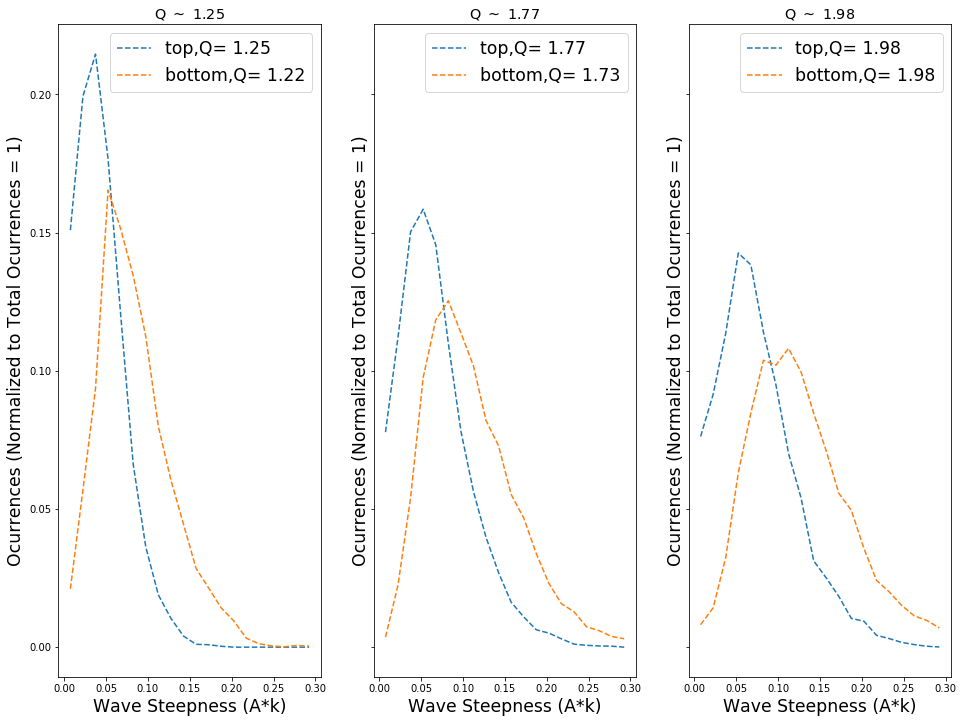

In [245]:
fig, axs = plt.subplots(1,3,sharey=True,figsize=(16,12))
axes = axs.flatten()
#List number of files with different flows in ascendant order
list_top = [215,216,217]
list_bottom = [214,211,209]
#scales are different as we took images in different days
scale1 = 44.15
scale2 = 47.46

#loop for the elements in the list
for i in range(3):
    num1 = list_top[i]
    num2 = list_bottom[i]
    #Extract data Files
    txt_name_2cm = 'sobel_left'+str(num1)+'.txt'
    txt_name_4cm = 'sobel_left'+str(num2)+'.txt'
    data_2 = np.loadtxt(txt_name_2cm,unpack=True)
    data_4 = np.loadtxt(txt_name_4cm,unpack=True)
    #Extract flow data
    name_flow_2cm = '../flowmeter/FlowMeterData_'+str(num1)+'.lvm'
    name_flow_4cm = '../flowmeter/FlowMeterData_'+str(num2)+'.lvm'
    t,flow2 = Phot.lvm_unpack(name_flow_2cm)
    mean_flow2 = Phot.Mean_Flow(flow2)
    t,flow4 = Phot.lvm_unpack(name_flow_4cm)
    mean_flow4 = Phot.Mean_Flow(flow4)
    #Alocate space for data
    
    #We assume the number of analyzed images in both is the same
    no_images = data_2.shape[0]
    l_2 = np.zeros((no_images,data_2.shape[1]))
    l_4 = np.zeros((no_images,data_4.shape[1]))
    
    for j in range(no_images):
        #Smoothing data line by line and fill the data matrixes
        wave_2 = Phot.smooth(data_2[j,:],window_len=100,window='hanning')
        wave_4 = Phot.smooth(data_4[j,:],window_len=100,window='hanning')
        l_2[j,:] = wave_2
        l_4[j,:] = wave_4
        
    #ANALYSIS FOR THE 2cm
    #Make zero crossings in data
    waves_2 = Phot.substract_zero_crossing(l_2)
    #Empty list to collect variable data
    indexes_2 = []
    A_2 = []
    L_2 = []
    crest_2 = []
    no_waves_2 = []
    #Loop for each timestep
    for j in range(0,no_images):
        #There are images where the output of Find_waves is empty
        # in that case we just store zeros in the corresponding lists
        try:
            #Find the troughs and collect the information
            sep = Phot.Find_waves(waves_2[j,:],'left')
            indexes_2.append(sep)
            no_waves_2.append(len(sep)-1)
            #separate each wave and calculate amplitude and wavelegth
            for k in range(len(sep)-1):
                onda = waves_2[j,sep[k]:sep[k+1]]
                wavelength = (sep[k+1]-sep[k])/scale1 #scaling dependant on images
                amplitude = abs(max(onda))/scale1     #scaling dependant on images
                A_2.append(amplitude)
                L_2.append(wavelength)
                crest_2.append(sep[k]+np.argmax(onda))
        except:
            indexes_2.append(0)
            no_waves_2.append(0)

    #ANALYSIS FOR THE 4cm
    #Make zero crossing in data
    waves_4 = Phot.substract_zero_crossing(l_4)
    #Empty lists to collect variable data
    indexes_4 = []
    A_4 = []
    L_4 = []
    crest_4 = []
    no_waves_4 = []
    #Loop for each time step
    for j in range(0,no_images):
        #There are images where the output of Find_waves is empty
        # in that case we just store zeros in the corresponding lists
        try:
            #Find the troughs and collect the information
            sep = Phot.Find_waves(waves_4[j,:],'left')
            indexes_4.append(sep)
            no_waves_4.append(len(sep)-1)
            #separate each wave and calculate amplitude and wavelegth
            for k in range(len(sep)-1):
                onda = waves_4[j,sep[k]:sep[k+1]]
                wavelength = (sep[k+1]-sep[k])/scale2  #scaling dependant on images
                amplitude = abs(min(onda))/scale2      #scaling dependant on images
                A_4.append(amplitude)
                L_4.append(wavelength)
                crest_4.append(sep[k]+np.argmin(onda))
        except:
            indexes_4.append(0)
            no_waves_4.append(0)
    #Calculate wavenumber, steepness and their errors    
    K_2 = 2*np.pi/np.array(L_2)
    K_4 = 2*np.pi/np.array(L_4)
    dK_2 = 0.02*K_2/np.array(L_2)
    dK_4 = 0.02*K_4/np.array(L_4)
    steepness_2 = A_2*K_2
    steepness_4 = A_4*K_4
    dst_2 = 0.02*K_2*(1.+A_2/np.array(L_2))
    dst_4 = 0.02*K_4*(1.+A_4/np.array(L_4))
    #Calculate the weigth of data for histogram
    we_ak_2 = 1./dst_2
    we_ak_4 =1./dst_4
    #Make weigthed normalized histograms
    hist_2, bins_2 = np.histogram(steepness_2,bins=20,range=(0,0.3),weights=we_ak_2,density=True)
    hist_4, bins_4 = np.histogram(steepness_4,bins=20,range=(0,0.3),weights=we_ak_4,density=True)
    
    #numpy.histogram integral is one when bins are size one, so we need to
    # multiply by the bin sizes to renormalize
    norm_2 = hist_2*abs(bins_2[1]-bins_2[0])
    norm_4 = hist_4*abs(bins_4[1]-bins_4[0])
    #mean steepness
    ind_2 = np.mean(steepness_2)
    ind_4 = np.mean(steepness_4)
    center_2 = (bins_2[:-1] + bins_2[1:]) / 2
    center_4 = (bins_4[:-1] + bins_4[1:]) / 2
    axes[i].plot(center_2,norm_2,'--',label='top,Q= %.2f' % (mean_flow2))
    axes[i].plot(center_4,norm_4,'--',label='bottom,Q= %.2f' % (mean_flow4))
    axes[i].legend(fontsize='xx-large')
    axes[i].set_xlabel('Wave Steepness (A*k)',fontsize='xx-large')
    axes[i].set_ylabel('Ocurrences (Normalized to Total Ocurrences = 1)',fontsize='xx-large')
    axes[i].set_title(r'Q $\sim$ %.2f '%mean_flow2,fontsize='x-large')
plt.show()

### Convergence of histograms in time

In [71]:
num = 201
txt_name_r = 'sobel_right'+str(num)+'.txt'
txt_name_l = 'sobel_left'+str(num)+'.txt'
data_l = np.loadtxt(txt_name_l,unpack=True)
data_r = np.loadtxt(txt_name_r,unpack=True)
name_flow = '../flowmeter/FlowMeterData_'+str(num)+'.lvm'
t,flow = Phot.lvm_unpack(name_flow)
mean_flow = Phot.Mean_Flow(flow)
    
no_images = data_l.shape[0]
left = np.zeros((no_images,800))
right = np.zeros((no_images,800))
for j in range(no_images):
    wave_l = Phot.smooth(data_l[j,:800],window_len=100,window='hanning')
    wave_r = Phot.smooth(data_r[j,:800],window_len=100,window='hanning')
    left[j,:] = wave_l
    right[j,:] = wave_r

waves_left = Phot.substract_zero_crossing(left)
waves_right = Phot.substract_zero_crossing(right)

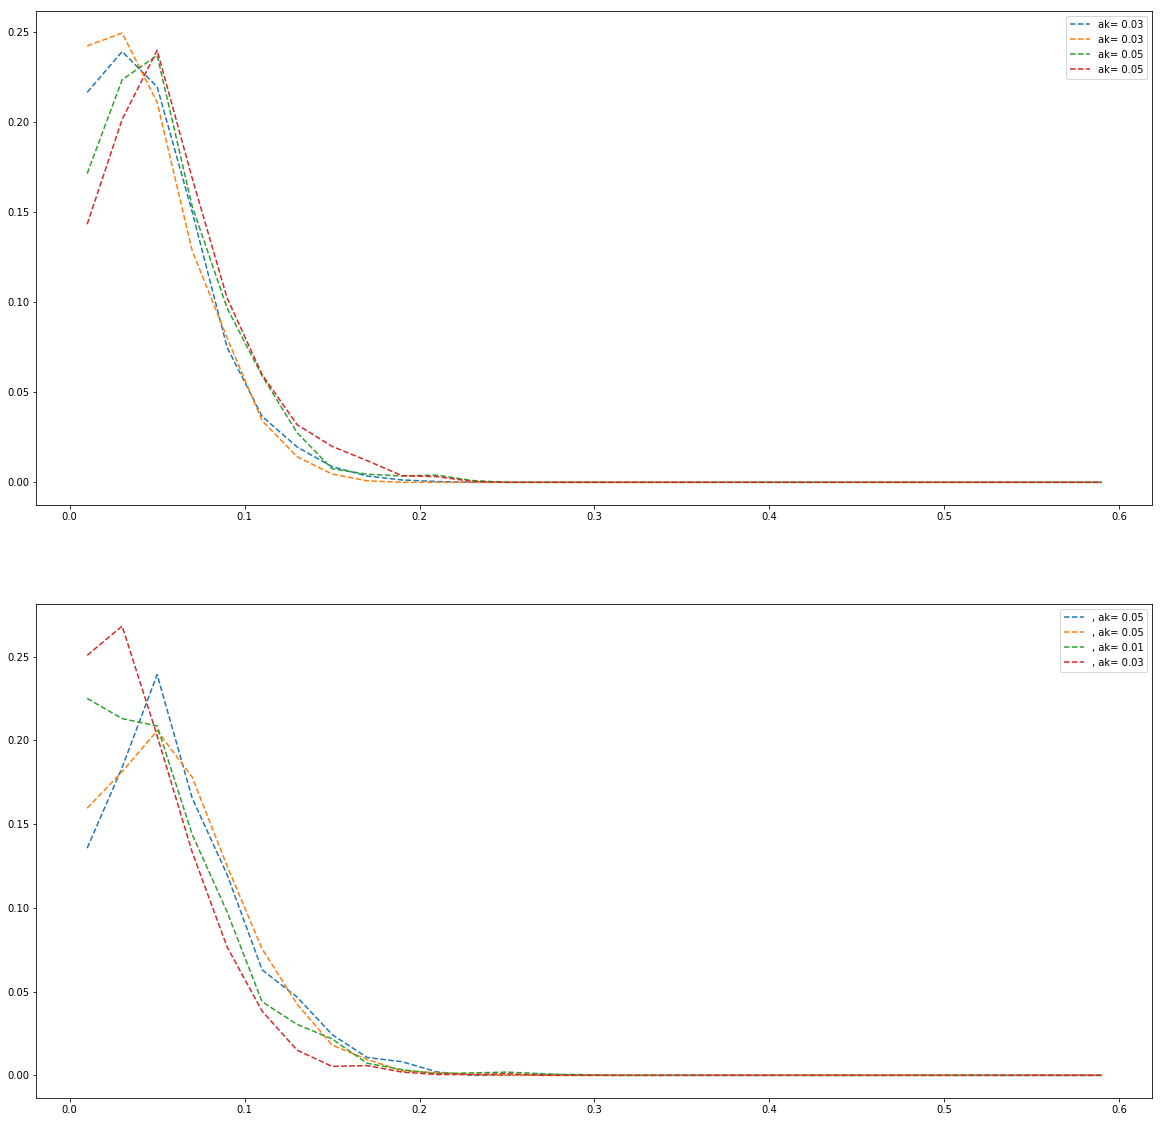

In [73]:
fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)

for i in range(0,4):
    indexes_left = []
    A_left = []
    L_left = []
    crest_left = []
    no_waves_left = []

    for j in range(2*i*1000,2*(i+1)*1000):
        try:
            sep = Phot.Find_waves(waves_left[j,:],'left')
            indexes_left.append(sep)
            no_waves_left.append(len(sep)-1)
            for k in range(len(sep)-1):
                onda = waves_left[j,sep[k]:sep[k+1]]
                wavelength = (sep[k+1]-sep[k])/49.07
                amplitude = max(onda)/49.07
                A_left.append(amplitude)
                L_left.append(wavelength)
                crest_left.append(sep[k]+np.argmax(onda))
        except:
            indexes_left.append(0)
            no_waves_left.append(0)
    K_left = 2*np.pi/np.array(L_left)
    steepness_left = A_left*K_left
    hist_left, bins_left = np.histogram(steepness_left,bins=30,range=(0,0.6))
    total_l = len(K_left)
    norm_l = hist_left/float(total_l)
    ind_l = np.argmax(hist_left)
    center_l = (bins_left[:-1] + bins_left[1:]) / 2
    ax1.plot(center_l,norm_l,'--',label= 'ak= %.2f' % center_l[ind_l])
    
    
    indexes_right = []
    A_right = []
    L_right = []
    crest_right = []
    no_waves_right = []

    for j in range(2*i*1000,2*(i+1)*1000):
        try:
            sep = Phot.Find_waves(waves_right[j,:],'right')
            indexes_right.append(sep)
            no_waves_right.append(len(sep)-1)
            for k in range(len(sep)-1):
                onda = waves_right[j,sep[k]:sep[k+1]]
                wavelength = (sep[k+1]-sep[k])/49.07  
                amplitude = abs(min(onda))/49.07
                A_right.append(amplitude)
                L_right.append(wavelength)
                crest_right.append(sep[k]+np.argmin(onda))
        except:
            indexes_right.append(0)
            no_waves_right.append(0)
                
    K_right = 2*np.pi/np.array(L_right)
    steepness_right = A_right*K_right
    hist_right, bins_right = np.histogram(steepness_right,bins=30,range=(0,0.6))
        
    total_r = len(K_right)
    norm_r = hist_right/float(total_r)
    ind_r = np.argmax(hist_right)
    center_r = (bins_right[:-1] + bins_right[1:]) / 2
    ax2.plot(center_r,norm_r,'--',label=', ak= %.2f' % center_r[ind_r])
    
ax1.legend()
ax2.legend()
plt.show()

## Classes for notebook importer

In [2]:
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

In [3]:
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
            for cell in nb.cells:
                if cell.cell_type == 'code':
                    # transform the input to executable Python
                    code = self.shell.input_transformer_manager.transform_cell(cell.source)
                    # run the code in themodule
                    exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

In [4]:
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

In [5]:
sys.meta_path.append(NotebookFinder())

In [6]:
import Photron_Analysis_Functions as Phot

importing Jupyter notebook from Photron Analysis Functions.ipynb
